In [1]:
%matplotlib inline
import psycopg2
import numpy as np
import numpy.ma as ma
from pyiem import reference
from pyiem.plot import MapPlot
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:

POSTGIS = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
cursor = POSTGIS.cursor()

In [8]:
lons = []
lats = []
cursor.execute("""SELECT ST_x(geom), ST_y(geom) from idot_snowplow_2013_2014 WHERE
 valid BETWEEN '2016-12-06' and '2016-12-07' and velocity > 0""")
for row in cursor:
    lons.append( row[0] )
    lats.append( row[1] )
    

In [3]:
cursor.execute("""SELECT ST_asEWKT(ST_Buffer(ST_Collect(geom),0)) from warnings_2014 where phenomena = 'BZ'
 and significance = 'W' and issue > '2014-01-26' and wfo in ('DMX','DVN', 'ARX') and substr(ugc, 1,2) = 'IA'""")

from shapely.wkt import loads
row = cursor.fetchone()
geom = loads(row[0][10:])


In [9]:
H2, xedges, yedges = np.histogram2d(lons, lats, 
                                       bins=(int((reference.IA_EAST-reference.IA_WEST)*25),
                                             int((reference.IA_NORTH-reference.IA_SOUTH)*25)),
                                       range=[[reference.IA_WEST,reference.IA_EAST],
                                              [reference.IA_SOUTH,reference.IA_NORTH],
                                              ])
H3 = ma.array(H2)
H3.mask = np.where(H2 < 1, True, False)

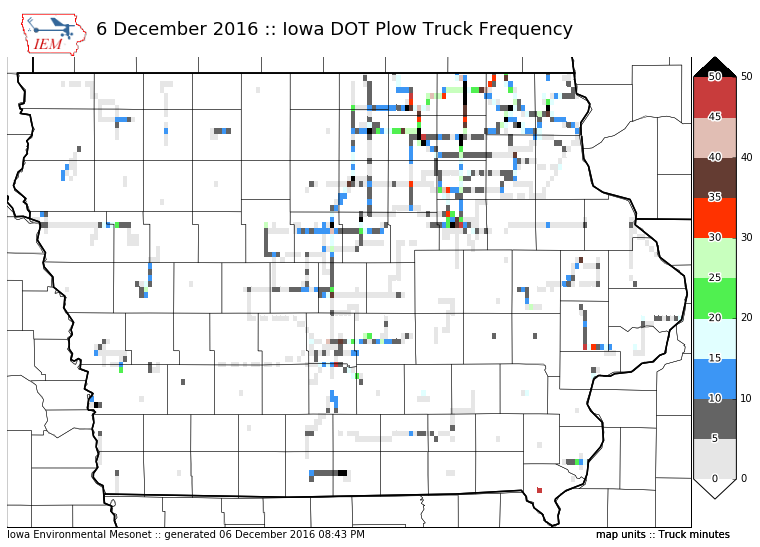

In [10]:


m = MapPlot(title='6 December 2016 :: Iowa DOT Plow Truck Frequency')

yy,xx = np.meshgrid(yedges,xedges)
#print np.shape(xx), np.max(xx)
#print np.shape(H2)
#print np.shape(xedges)
#print np.shape(yedges)
m.pcolormesh(xx, yy, H3, np.arange(0,52,5), latlon=True, units='Truck minutes')
patches = []
#a = np.asarray(geom.exterior)
#x,y = m.map(a[:,0], a[:,1])
#m.ax.plot(x,y, color='yellow', lw=3., zorder=2)
#m.ax.plot(x,y, color='k', lw=1., zorder=3)
m.drawcounties()    
m.postprocess(filename='test.png')
